In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
pattern = (
    r'(?P<grouping>base|upos|lego)_'
    r'(?P<type>bpe|unigram|wordpiece)_'
    r'(?P<vocab_size>\d+)'
    r'(?:_(?P<weighting>grammatical|lexical))?'
    r'(?:_(?P<allocation>weightedproportional|proportional))?'
    r'_tokenizer'
)


english_df = pd.read_csv('D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Benchmark output/english_benchmark_output.csv')
tokenizer_split = english_df['tokenizer'].str.extract(pattern)
tokenizer_split['weighting'] = tokenizer_split['weighting'].fillna('equal')
tokenizer_split['allocation'] = tokenizer_split['allocation'].fillna('proportional')
english_df = pd.concat([english_df, tokenizer_split[['grouping', 'vocab_size', 'allocation', 'weighting']]], axis=1)
english_df['vocab_size'] = english_df['vocab_size'].astype(int)

turkish_df = pd.read_csv('D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Benchmark output/turkish_benchmark_output.csv')
tokenizer_split = turkish_df['tokenizer'].str.extract(pattern)
tokenizer_split['weighting'] = tokenizer_split['weighting'].fillna('equal')
tokenizer_split['allocation'] = tokenizer_split['allocation'].fillna('proportional')
turkish_df = pd.concat([turkish_df, tokenizer_split[['grouping', 'vocab_size', 'allocation', 'weighting']]], axis=1)
turkish_df['vocab_size'] = turkish_df['vocab_size'].astype(int)

english_df['language'] = 'English'
turkish_df['language'] = 'Turkish'
df = pd.concat([english_df, turkish_df], ignore_index=True)
df = df[['type', 'language', 'grouping', 'vocab_size', 'allocation', 'weighting', 'micro_avg_f1']]

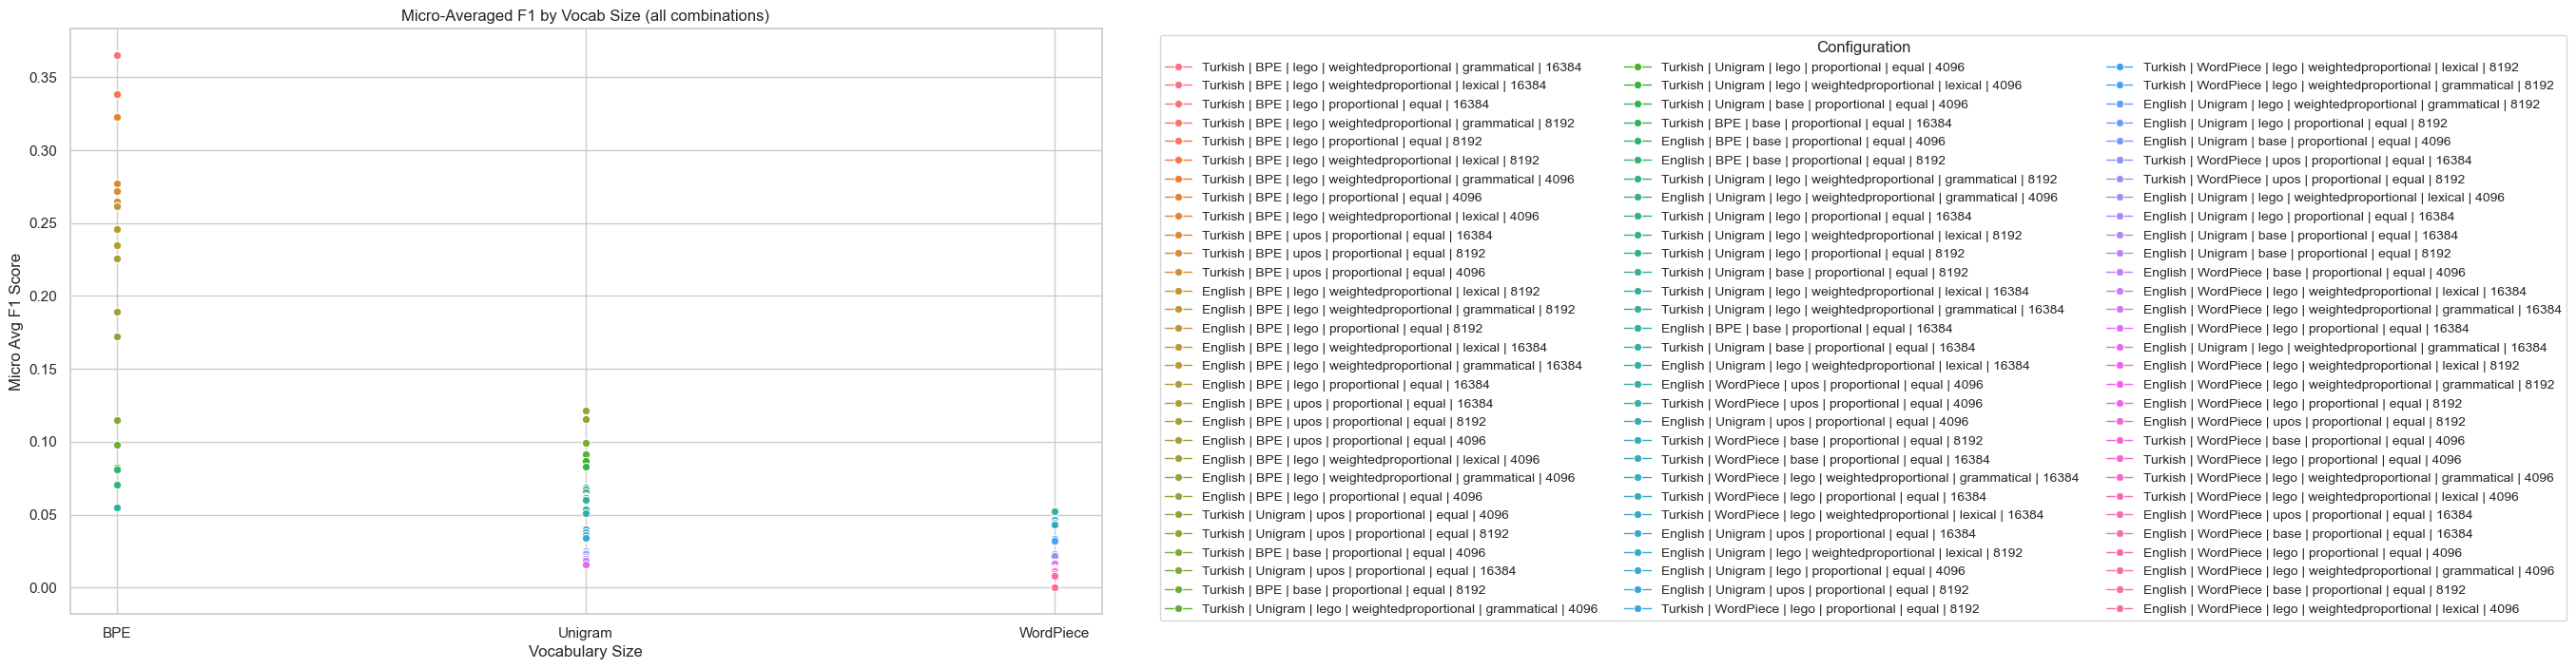

<Figure size 800x600 with 0 Axes>

In [3]:
color_map = dict(zip(df['type'].unique(), sns.color_palette("tab10", n_colors=df['type'].nunique())))
marker_map = dict(zip(df['grouping'].unique(), ['o', 's', 'D', '^', 'v', 'P', '*']))

df['label'] = (
    df['language'] + ' | ' +
    df['type'] + ' | ' +
    df['grouping'] + ' | ' +
    df['allocation'] + ' | ' +
    df['weighting'] + ' | ' +
    df['vocab_size'].astype(str)
)
label_scores = (
    df.groupby('label')['micro_avg_f1']
    .max()
    .sort_values(ascending=False)
)
sorted_labels = label_scores.index.tolist()

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

sns.lineplot(
    data=df,
    x='type',
    y='micro_avg_f1',
    hue='label',
    hue_order=sorted_labels,
    marker='o',
    linewidth=1
)

plt.title('Micro-Averaged F1 by Vocab Size (all combinations)')
plt.xlabel('Vocabulary Size')
plt.ylabel('Micro Avg F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3, fontsize='small', title='Configuration')
plt.savefig(f"D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/combinations.pdf", format='pdf', bbox_inches='tight')
handles, labels = plt.gca().get_legend_handles_labels()
plt.show()

fig_leg = plt.figure(figsize=(8, 6)) 
fig_leg.legend(handles, labels, loc='center', ncol=3, title='Configuration', fontsize='small')

fig_leg.tight_layout()
fig_leg.savefig("D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/legend_3col.pdf", format='pdf', bbox_inches='tight')
fig_leg = plt.figure(figsize=(8, 6)) 
fig_leg.legend(handles, labels, loc='center', ncol=2, title='Configuration', fontsize='small')

fig_leg.tight_layout()
fig_leg.savefig("D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/legend_2col.pdf", format='pdf', bbox_inches='tight')
plt.close(fig_leg)

In [4]:
df_bar = df[df['allocation'] == 'proportional']
grouping_pairs = [('upos', 'base'), ('lego', 'base'), ('upos', 'lego')]
diff_df_list = []

for (lang, typ), group in df_bar.groupby(['language', 'type']):
    for grp1, grp2 in grouping_pairs:
        # Pivot to get both F1 scores side by side
        pivot = group[group['grouping'].isin([grp1, grp2])].pivot(
            index='vocab_size', columns='grouping', values='micro_avg_f1'
        )
        if grp1 in pivot.columns and grp2 in pivot.columns:
            diff = pivot[grp1] - pivot[grp2]
            diff_df = diff.reset_index()
            diff_df['type'] = typ
            diff_df['language'] = lang
            diff_df['comparison'] = f"{grp1} - {grp2}"
            diff_df_list.append(diff_df)
diff_df_all = pd.concat(diff_df_list, ignore_index=True)
diff_df_all = diff_df_all.rename(columns={0: 'f1_diff'})
diff_df_all['group'] = (
    diff_df_all['language'] + ' | ' +
    diff_df_all['type']
)

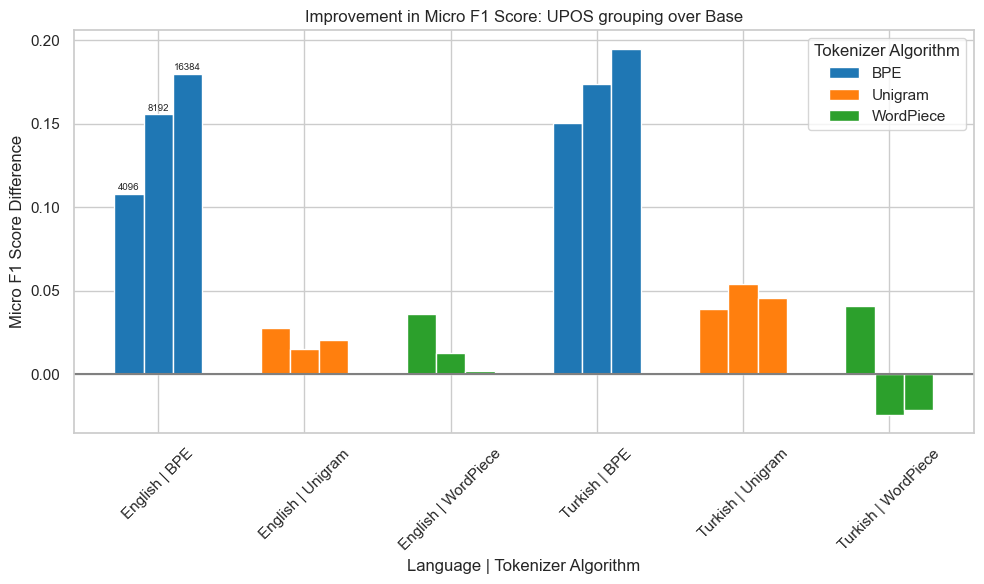

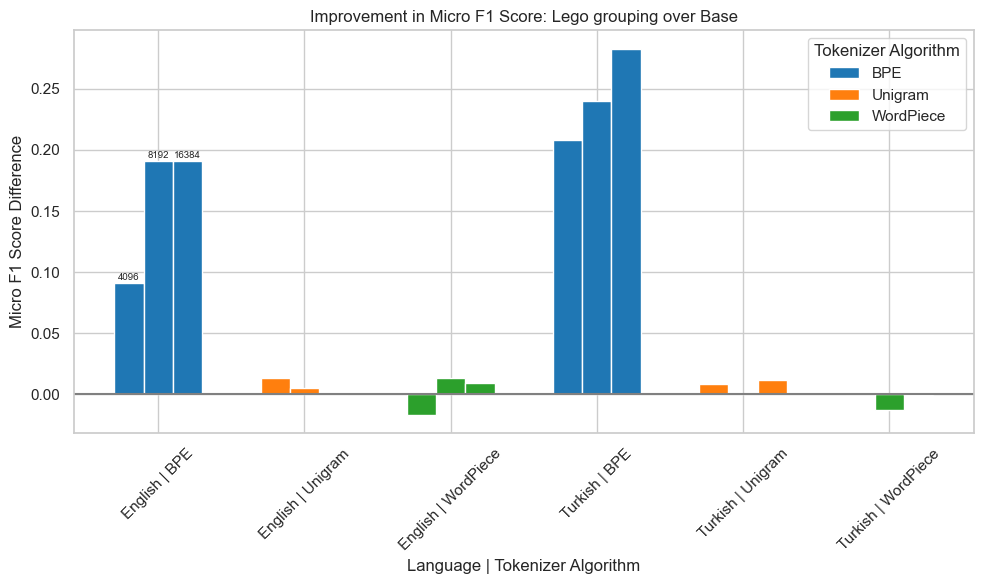

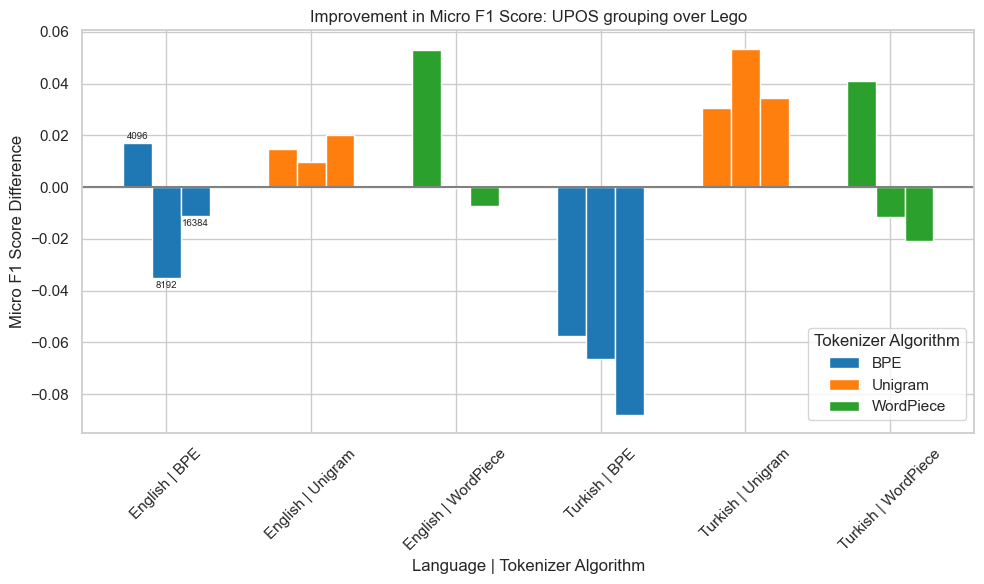

In [5]:
sns.set(style='whitegrid')

comparisons = diff_df_all['comparison'].unique()
palette = dict(zip(diff_df_all['type'].unique(), sns.color_palette("tab10")))

for comp in comparisons:
    subset = diff_df_all[diff_df_all['comparison'] == comp].copy()
    
    subset['group'] = subset['language'] + ' | ' + subset['type']
    groups = subset['group'].unique()
    vocab_sizes = sorted(subset['vocab_size'].unique())

    bar_width = 0.2
    x_ticks = []
    x_tick_labels = []

    plt.figure(figsize=(10, 6))
    seen_types = set()

    for i, group in enumerate(groups):
        group_data = subset[subset['group'] == group]
        for j, vocab in enumerate(vocab_sizes):
            row = group_data[group_data['vocab_size'] == vocab]
            if row.empty:
                continue
            x = i + j * bar_width - bar_width  # center bars

            typ = row['type'].values[0]
            color = palette[typ]
            label = typ if typ not in seen_types else None
            seen_types.add(typ)

            bar = plt.bar(
                x,
                row['f1_diff'].values[0],
                width=bar_width,
                color=color,
                label=label,
            )

            # Annotate vocab_size above bar
            if i == 0:
                if row['f1_diff'].values[0] > 0:
                    plt.text(
                        x,
                        row['f1_diff'].values[0] + 0.001,  # offset
                        str(vocab),
                        ha='center',
                        va='bottom',
                        fontsize=7
                    )
                else:
                    plt.text(
                        x,
                        row['f1_diff'].values[0] - 0.001,  # offset
                        str(vocab),
                        ha='center',
                        va='top',
                        fontsize=7
                    )

        x_ticks.append(i)
        x_tick_labels.append(group)

    plt.axhline(0, color='gray', linestyle='-', linewidth=1.5)


    first, second = comp.split(' - ')
    pretty_names = {
        'upos': 'UPOS',
        'base': 'Base',
        'lego': 'Lego'
    }
    first = pretty_names.get(first, first)
    second = pretty_names.get(second, second)

    plt.title(f'Improvement in Micro F1 Score: {first} grouping over {second}')
    plt.xlabel('Language | Tokenizer Algorithm')
    plt.ylabel('Micro F1 Score Difference')
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=45)
    if comp == "upos - lego":
        plt.legend(title='Tokenizer Algorithm', bbox_to_anchor=(1, 0.28))
    else:
        plt.legend(title='Tokenizer Algorithm', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    filename = comp.replace(" ", "_").replace("|", "").replace("/", "_")
    plt.savefig(f"D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/{filename}.pdf", format='pdf')

    plt.show()


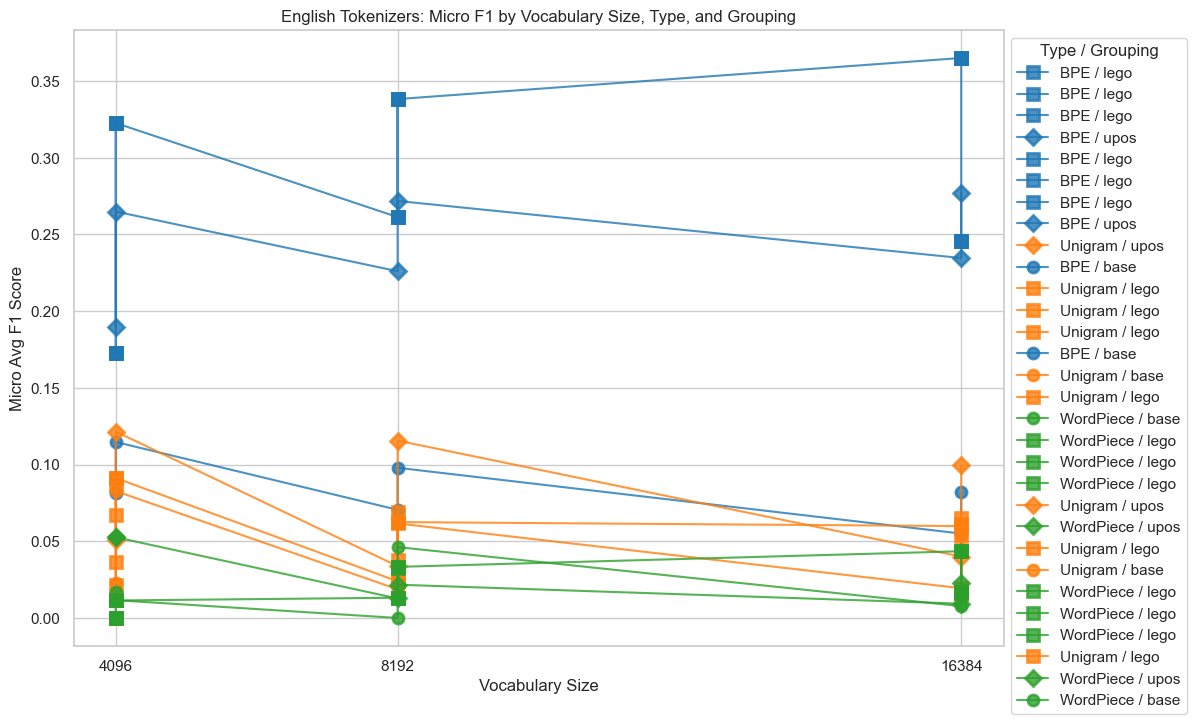

In [6]:
color_map = dict(zip(df['type'].unique(), sns.color_palette("tab10", n_colors=df['type'].nunique())))
marker_map = dict(zip(df['grouping'].unique(), ['o', 's', 'D', '^', 'v', 'P', '*']))

plt.figure(figsize=(12, 8))
lines_dict = {}

for (typ, grp), group_data in df.groupby(['type', 'grouping']):
    sorted_group = group_data.sort_values('vocab_size')
    line, = plt.plot(
        sorted_group['vocab_size'],
        sorted_group['micro_avg_f1'],
        marker=marker_map[grp],
        color=color_map[typ],
        markersize=8,
        markeredgewidth=2,
        linestyle='-',
        alpha=0.8,
        label=f"{typ} / {grp}"
    )
    lines_dict[(typ, grp)] = line

# Legend for color (type)
legend_elements_type = [
    Line2D([0], [0], marker='o', color='w', label=typ, markerfacecolor=color_map[typ], markersize=8)
    for typ in color_map
]

# Legend for marker (grouping)
legend_elements_grouping = [
    Line2D([0], [0], marker=marker_map[grp], color='k', label=grp, markerfacecolor='gray', markersize=8)
    for grp in marker_map
]

plt.xlabel('Vocabulary Size')
plt.xticks(sorted(df['vocab_size'].unique()))
plt.ylabel('Micro Avg F1 Score')
plt.title('English Tokenizers: Micro F1 by Vocabulary Size, Type, and Grouping')

sort_df = df[df['vocab_size'] == 16384][['type', 'grouping', 'micro_avg_f1']]
sort_df['key'] = list(zip(sort_df['type'], sort_df['grouping']))
sorted_keys  = sort_df.sort_values('micro_avg_f1', ascending=False)['key'].tolist()
sorted_handles = [lines_dict[key] for key in sorted_keys if key in lines_dict]
plt.legend(handles=sorted_handles, title='Type / Grouping', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

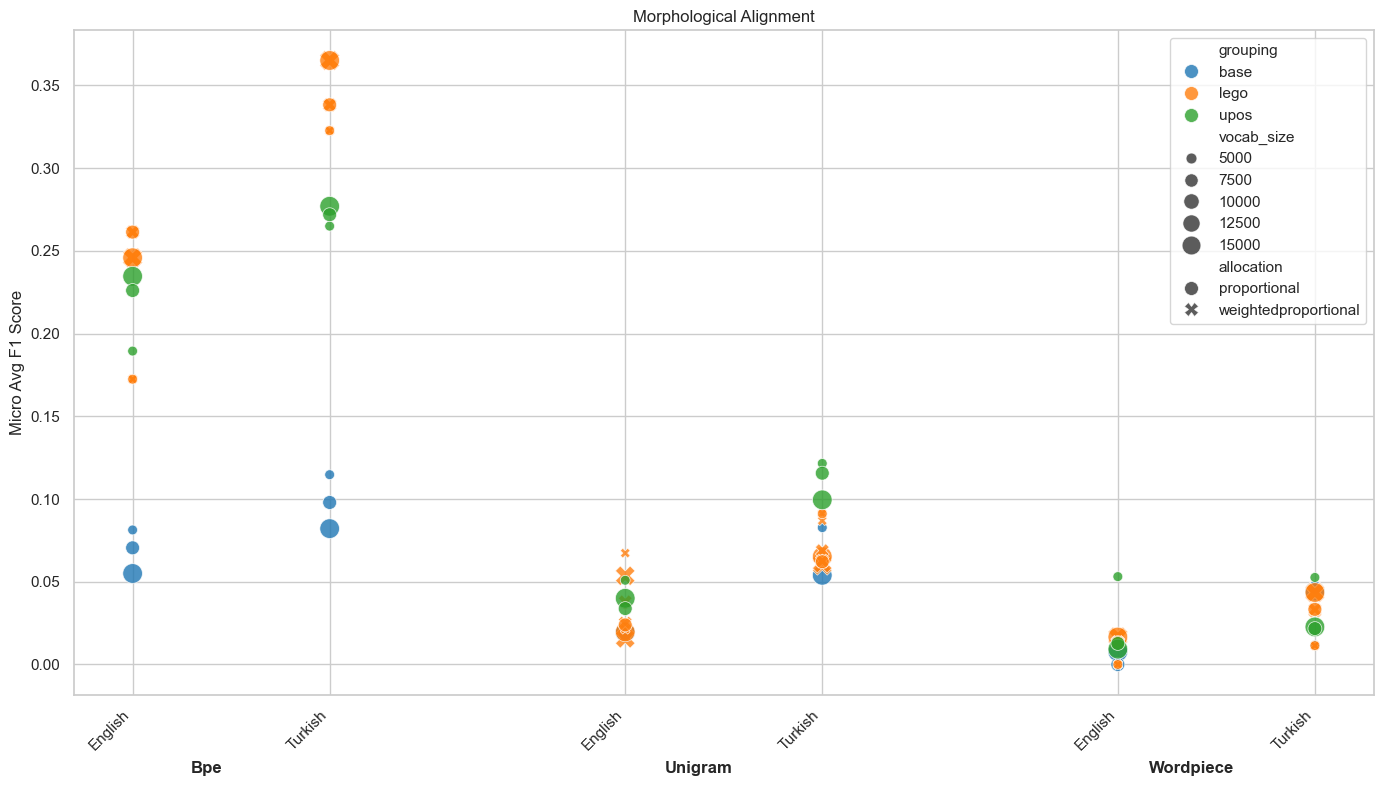

In [7]:
color_map = dict(zip(df['type'].unique(), sns.color_palette("tab10", n_colors=df['type'].nunique())))
marker_map = dict(zip(df['grouping'].unique(), ['o', 's', 'D', '^', 'v', 'P', '*']))
df_scatter = df.copy()

df_scatter['label'] = (
    df_scatter['language'] + ' | ' +
    df_scatter['type'] + ' | ' +
    df_scatter['grouping'] + ' | ' +
    df_scatter['allocation'] + ' | ' +
    df_scatter['weighting'] + ' | ' +
    df_scatter['vocab_size'].astype(str)
)

type_order = df_scatter['type'].unique().tolist()
type_to_x = {t: i for i, t in enumerate(type_order)}
language_order = ['english', 'turkish']
language_offsets = {'English': 0, 'Turkish': +0.4}
df_scatter['x_pos'] = df_scatter.apply(lambda row: 
    type_to_x[row['type']] 
    + language_offsets.get(row['language']
    , 0), axis=1
)

fig, ax = plt.subplots(figsize=(14, 8))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_scatter,
    x='x_pos',
    y='micro_avg_f1',
    hue='grouping',
    size='vocab_size',
    sizes=(50, 200),
    legend='brief',
    palette='tab10',
    s=100,
    ax=ax,
    alpha=0.8,
    style='allocation',
)



label_scores = (
    df_scatter.groupby('label')['micro_avg_f1']
    .max()
    .sort_values(ascending=False)
)
sorted_labels = label_scores.index.tolist()

language_ticks = []
language_labels = []
offset = 0.4

for t in type_order:
    base_pos = type_to_x[t]
    for i, lang in enumerate(language_order):
        language_ticks.append(base_pos + i * offset)
        language_labels.append(lang.capitalize())

ax.set_xticks(language_ticks)
ax.set_xticklabels(language_labels, rotation=45, ha='right')

for t in type_order:
    base_pos = type_to_x[t]
    center_pos = base_pos + offset / 2 - 0.05
    ax.text(center_pos, ax.get_ylim()[0] - 0.02 - 0.05*(ax.get_ylim()[1] - ax.get_ylim()[0]),  # just below x-axis
            t.capitalize(),
            ha='center',
            va='top',
            fontsize=12,
            fontweight='bold')


ax.set_xlabel(' ')
plt.ylabel('Micro Avg F1 Score')
plt.title('Morphological Alignment')
#plt.legend().remove()
plt.tight_layout()
plt.savefig(f"D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/scatter_language_shift.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [8]:
df

,type,language,grouping,vocab_size,allocation,weighting,micro_avg_f1,label
0,BPE,English,base,16384,proportional,equal,0.0550,English | BPE | base | proportional | equal | ...
1,BPE,English,base,4096,proportional,equal,0.0813,English | BPE | base | proportional | equal | ...
2,BPE,English,base,8192,proportional,equal,0.0705,English | BPE | base | proportional | equal | ...
3,Unigram,English,base,16384,proportional,equal,0.0194,English | Unigram | base | proportional | equa...
4,Unigram,English,base,4096,proportional,equal,0.0230,English | Unigram | base | proportional | equa...
...,...,...,...,...,...,...,...,...
85,Unigram,Turkish,upos,4096,proportional,equal,0.1215,Turkish | Unigram | upos | proportional | equa...
86,Unigram,Turkish,upos,8192,proportional,equal,0.1156,Turkish | Unigram | upos | proportional | equa...
87,WordPiece,Turkish,upos,16384,proportional,equal,0.0227,Turkish | WordPiece | upos | proportional | eq...
88,WordPiece,Turkish,upos,4096,proportional,equal,0.0526,Turkish | WordPiece | upos | proportional | eq...


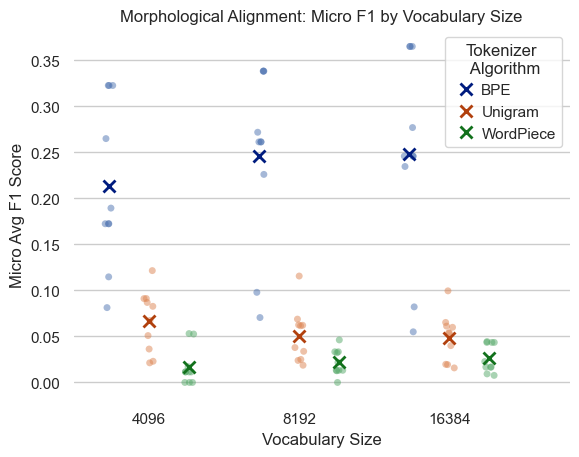

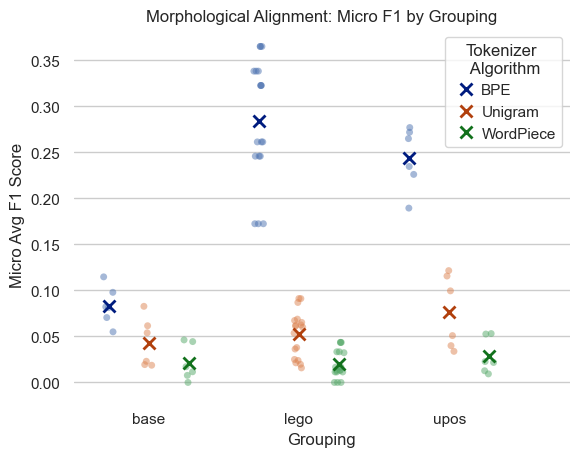

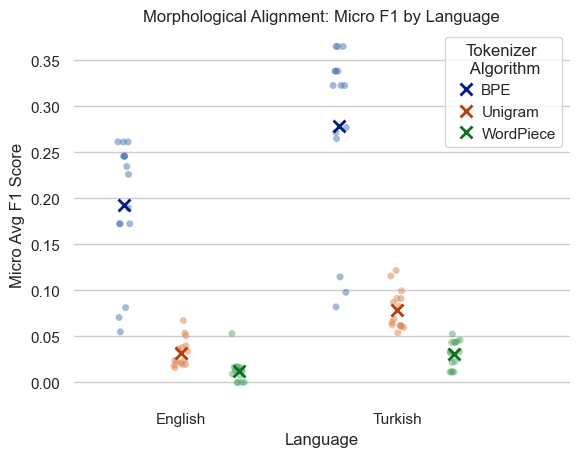

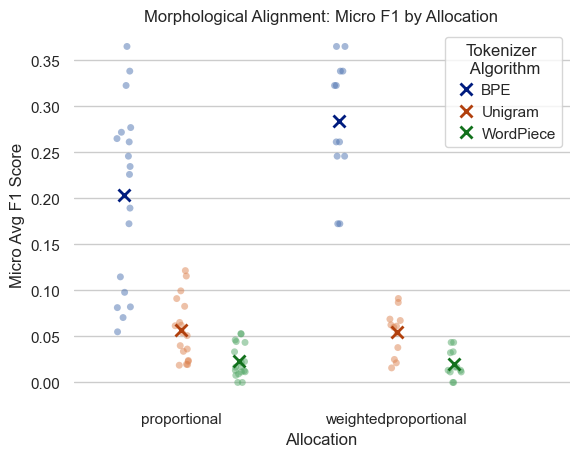

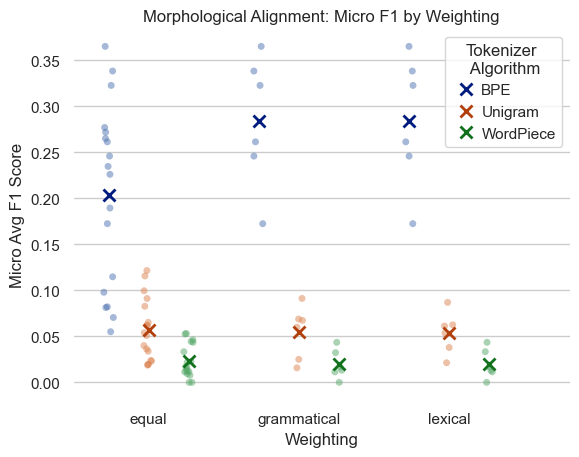

In [9]:
parameters = ['vocab_size', 'grouping', 'language', 'allocation', 'weighting']
pretty_names = {
    'vocab_size': 'Vocabulary Size',
    'grouping': 'Grouping',
    'language': 'Language',
    'allocation': 'Allocation',
    'weighting': 'Weighting'
}
for param in parameters:

    sns.set_theme(style="whitegrid")

    f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)

    sns.stripplot(
        data=df, x=param, y="micro_avg_f1", hue="type",
        dodge=True, alpha=.5, zorder=1, legend=False,
    )

    sns.pointplot(
        data=df, x=param, y="micro_avg_f1", hue="type",
        dodge=.8 - .8 / 3, palette="dark", errorbar=None,
        markers="x", markersize=8, linestyle="none",
    )

    plt.title(f'Morphological Alignment: Micro F1 by {pretty_names[param]}')
    plt.xlabel(pretty_names[param])
    plt.ylabel('Micro Avg F1 Score')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1] + 0.3)

    sns.move_legend(
        ax, loc='upper right', ncol=1, frameon=True, columnspacing=1, handletextpad=0, title='Tokenizer\n Algorithm',
    )
    plt.savefig(f"D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/stripplot_{param}.pdf", format='pdf', bbox_inches='tight')
    plt.show()
